## Description

In this notebook, we compare the outcomes of different approaches to annotation of spectra of lipids in the context of MS imaging:  
  - Accurate mass matching in the average spectrum (a commonly used approach)
  - Matching theoretical spectra to the average spectrum using `masserstein` 
  - Deconvolving each pixel independently with `masserstein`  
  
We use a custom set of lipid formulas downloaded from LIPID MAPS data base. The set of lipids is supplied with the notebook.  

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as rd
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
from venn import venn
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra
from collections import Counter

In [3]:
analyzed_mass_range = (700, 900)

Load the centroided MS images calculated in Notebook 2:

In [4]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
images = [cerebellum_centroided_image, bladder_centroided_image]
shapes = [cerebellum_image_shape, bladder_image_shape]
names = ['cerebellum', 'bladder']

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
raw_images = [cerebellum_profile_image, bladder_profile_image]

Load the average spectra calculated in Notebook 2:

In [9]:
average_spectra = []
average_spectrum_masses = []
for i, n in enumerate(names):
    sp = open(n + '_centroided_average_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(mz), float(intsy)) for mz, intsy in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    average_spectra.append(sp)
    average_spectrum_masses.append([x[0] for x in sp.confs])

In [10]:
profile_average_spectra = {}
for i, n in enumerate(names):
    sp = open(n + '_profile_summary_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(l[0]), float(l[1])) for l in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    profile_average_spectra[n] = sp

<IPython.core.display.Javascript object>


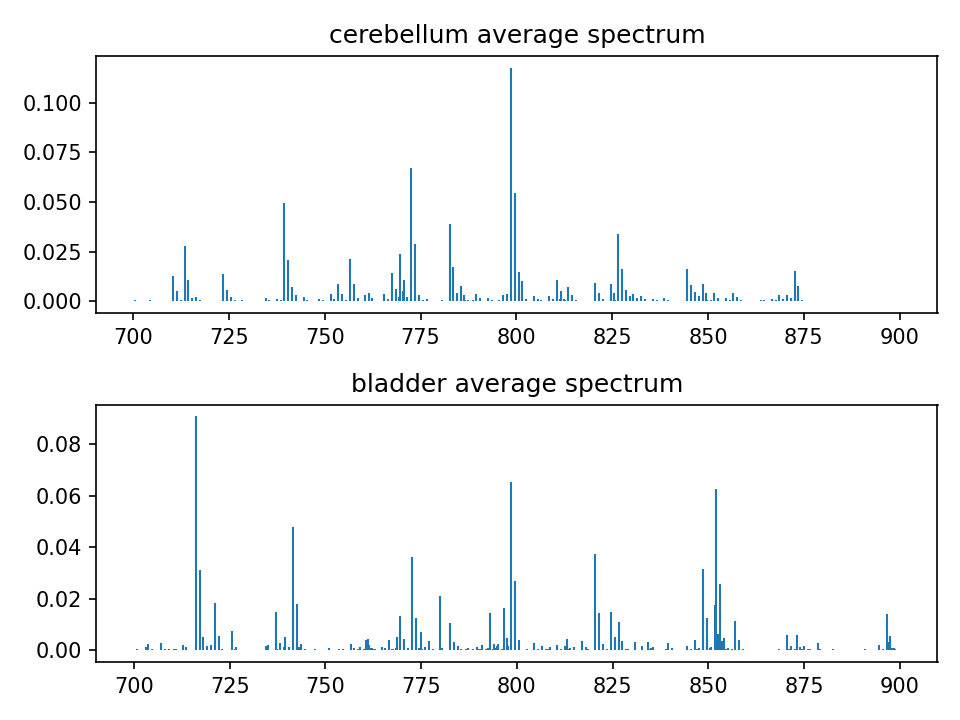

In [11]:
plt.figure()
for i, n in enumerate(names):
    plt.subplot(211+i)
    plt.title(n + ' average spectrum')
    average_spectra[i].plot()
plt.tight_layout()

Load the lipid formulas:

In [15]:
lipid_formulas = []
formula_to_subclasses = {}
formula_to_classes = {}
formula_to_IDs = {}
with open('selected_lipids_28032022.tsv') as h:
    for l in h:
        l = l.strip().split('\t')
        formula = l[3] 
        lipid_class = l[1]
        lipid_subclass = l[2]
        lipid_ID = l[0]
        if set(formula).issubset(set('CHNOP0123456789')): # skipping atypical formulas, e.g. with Deuterium
            lipid_formulas.append(formula)
            try:
                formula_to_subclasses[formula].append(lipid_subclass)
            except KeyError:
                formula_to_subclasses[formula] = [lipid_subclass]
            try:
                formula_to_classes[formula].append(lipid_class)
            except KeyError:
                formula_to_classes[formula] = [lipid_class]
            try:
                formula_to_IDs[formula].append(lipid_ID)
            except KeyError:
                formula_to_IDs[formula] = [lipid_ID]
lipid_formulas = list(set(lipid_formulas))
nb_of_classes = len(set([x for formula in formula_to_classes for x in formula_to_classes[formula]]))
nb_of_subclasses = len(set([x for formula in formula_to_subclasses for x in formula_to_subclasses[formula]]))
nb_of_IDs = len(set([x for formula in formula_to_IDs for x in formula_to_IDs[formula]]))
print('Loaded %i unique lipid formulas' % len(lipid_formulas))
print('Loaded %i unique lipid classes' % nb_of_classes)
print('Loaded %i unique lipid subclasses' % nb_of_subclasses)
print('Loaded %i unique lipid IDs' % nb_of_IDs)

Loaded 3523 unique lipid formulas
Loaded 2 unique lipid classes
Loaded 30 unique lipid subclasses
Loaded 14454 unique lipid IDs


Generate the lipid reference spectra (assuming a potassium adduct). We'll take the peaks that are at least 5% as high as the highest one.  

In [16]:
lipid_spectra = [Spectrum(formula=f, adduct='K', threshold=0.05) for f in lipid_formulas]
for s in lipid_spectra: 
    s.normalize()

We'll discard the spectra that are outside of our desired mass range

In [17]:
is_mass_within_range = [analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1] for s in lipid_spectra]
lipid_spectra = [s for t, s in zip(is_mass_within_range, lipid_spectra) if t]
lipid_formulas = [s for t, s in zip(is_mass_within_range, lipid_formulas) if t]
assert all(s.formula == f for s,f in zip(lipid_spectra, lipid_formulas))

formula_to_subclasses = {f: formula_to_subclasses[f] for f in lipid_formulas}
formula_to_classes = {f: formula_to_classes[f] for f in lipid_formulas}
formula_to_IDs = {f: formula_to_IDs[f] for f in lipid_formulas}

nb_of_classes = len(set([x for formula in formula_to_classes for x in formula_to_classes[formula]]))
nb_of_subclasses = len(set([x for formula in formula_to_subclasses for x in formula_to_subclasses[formula]]))
nb_of_IDs = len(set([x for formula in formula_to_IDs for x in formula_to_IDs[formula]]))

print('Retained %i lipid spectra' % len(lipid_spectra))
print('Retained %i classes' % nb_of_classes)
print('Retained %i subclasses' % nb_of_subclasses)
print('Retained %i IDs' % nb_of_IDs)

Retained 1206 lipid spectra
Retained 2 classes
Retained 22 subclasses
Retained 6922 IDs


Get the lipid classes corresponding to the remaining formulas:

Get the monoisotopic masses of our lipid ions:

In [18]:
lipid_masses = [s.confs[0][0] for s in lipid_spectra]

Get the positive control lipid spectra (we'll use them to check the deconvolution results)

In [19]:
control_lipid_names = ['PC(32:0)+K', 'PC(34:1)+K', 'PC(38:4)+K']
control_lipid_formulas = ['C40H80NO8P', 'C42H82NO8P', 'C46H84NO8P']
control_lipid_spectrum_ids = [lipid_formulas.index(f) for f in control_lipid_formulas]
assert all(lipid_spectra[i].formula == f for i,f in zip(control_lipid_spectrum_ids, control_lipid_formulas))

Example theoretical spectrum:

<IPython.core.display.Javascript object>


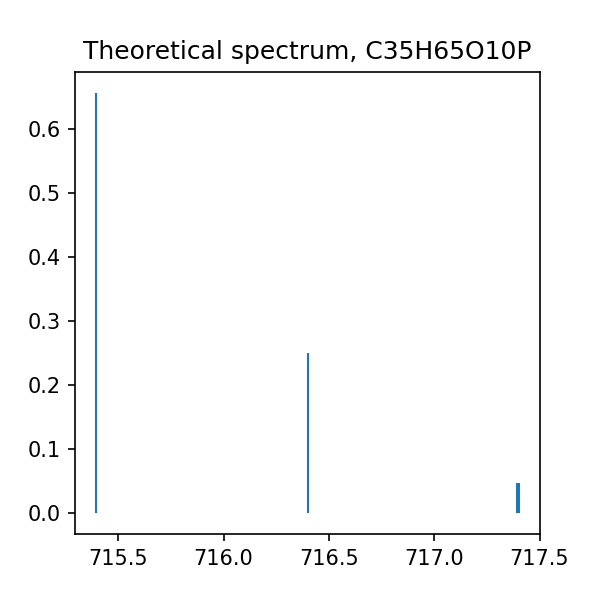

In [20]:
plt.figure(figsize=(4,4))
i = 1000
plt.title('Theoretical spectrum, %s' % lipid_spectra[i].formula)
lipid_spectra[i].plot()
plt.show()

## Mass matching accuracy settings

In [21]:
proportion_threshold = 1e-10
MTD = 0.005
MTD_th = 0.015

Note: MTD_th needs to be higher than MTD, otherwise the spectra can fit to "nothingness".   
MTD_th=0.005 gives us theoretical spectra without corresponding experimental signal.   
Another reason to set MTD_th > MTD is that it's easier to get too much signal in the analyzed spectrum (due to noise) than to miss some signal (due to LOD).  

## Whole-image Masserstein deconvolution

In [19]:
proportions_in_whole = [np.zeros(len(lipid_spectra)) for _ in range(2)]
analyzed_pixels = [0, 0]
control_lipid_images = [np.zeros(shp + (3, )) for shp in shapes]

# total signal images for normalization purposes:
global_tic_images = [np.zeros(sh) for sh in shapes] 
local_tic_images = [np.zeros(sh) for sh in shapes] 

for im_id, img in enumerate(images):
    print('Processing image:', names[im_id])
    s = time()
    for idx, (xcoord,ycoord,zcoord) in enumerate(img.coordinates):
        if not idx % 10000:
            print('Processing pixel number', idx)
        if rd.rand() >= 1:  # taking a given proportion of pixels 
            continue
        else:
            analyzed_pixels[im_id] += 1
        mz, intsy = img.getspectrum(idx)
        ##  Get the total signal before truncation: 
        global_tic = np.sum(intsy)
        global_tic_images[im_id][ycoord-1, xcoord-1] = global_tic
        # Truncate to the selected mass range:
        selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
        mz = mz[selected_range]
        intsy = intsy[selected_range]
        ##  Get the total signal in the truncated region:
        local_tic = np.sum(intsy)
        local_tic_images[im_id][ycoord-1, xcoord-1] = local_tic
        pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
        # Normalize for regression purposes
        pixel_spectrum.normalize()
        regression = estimate_proportions(pixel_spectrum, lipid_spectra, 
                                          MTD=MTD, MTD_th=MTD_th, MDC=1e-09, MMD=1, progress=False)
        pr_array = np.array(regression['proportions'])
        # Normalize the proportions so that they are equal the lipid's proportion
        # in the whole spectrum, not just in the analyzed mass range.
        pr_array = pr_array * local_tic / global_tic
        proportions_in_whole[im_id] += pr_array
        control_lipid_images[im_id][ycoord-1, xcoord-1, ...] = pr_array[control_lipid_spectrum_ids]
    e = time()
    print('Regression time:', e-s)

Processing image: cerebellum
Processing pixel number 0
Regression time: 1199.3821585178375
Processing image: bladder
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 8401.024608373642


In [28]:
for i, s in enumerate(shapes):
    proportions_in_whole[i] /= analyzed_pixels[i]

Check the distribution of total signal in the whole spectra and in the selected mass range: 

<IPython.core.display.Javascript object>


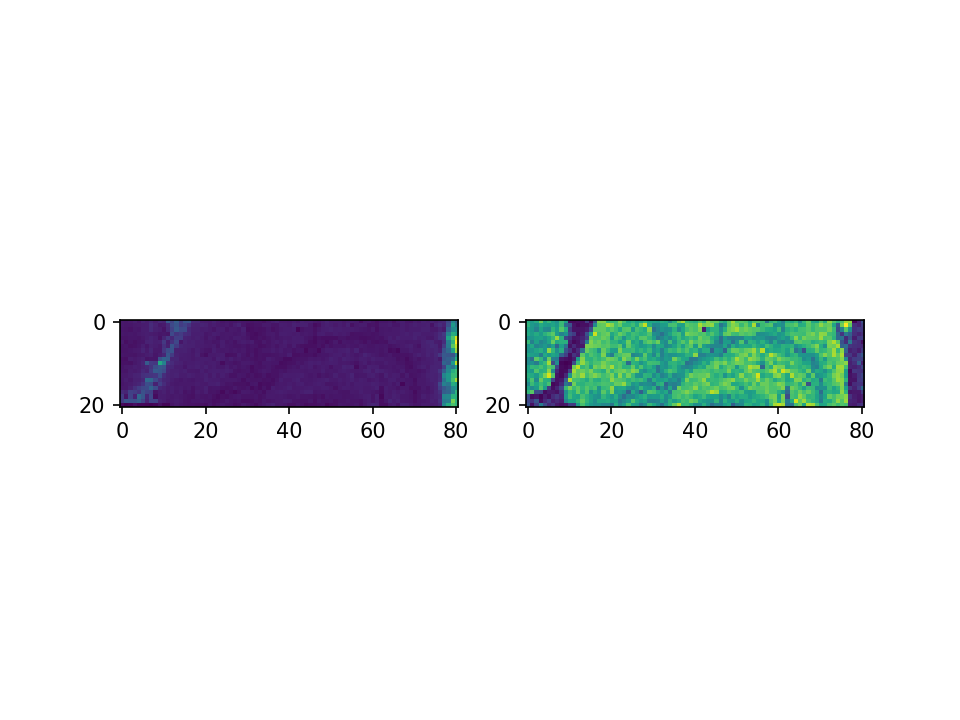

In [24]:
plt.figure()
plt.subplot(121)
plt.imshow(global_tic_images[0])
plt.subplot(122)
plt.imshow(local_tic_images[0])

Display the regression results for the control lipids, compare with their single peak images (note that we use only a selection of pixels so the images won't be the same):

In [25]:
control_peak_images = {i: np.zeros(shapes[i]+(3,)) for i in range(2)}
for i, s_id in enumerate(control_lipid_spectrum_ids):
    s = lipid_spectra[s_id]
    mz = s.confs[0][0]
    cer_img = profile_ion_image(cerebellum_profile_image, mz)
    bld_img = profile_ion_image(bladder_profile_image, mz)
    control_peak_images[0][...,i] = cer_img
    control_peak_images[1][..., i] = bld_img

<IPython.core.display.Javascript object>


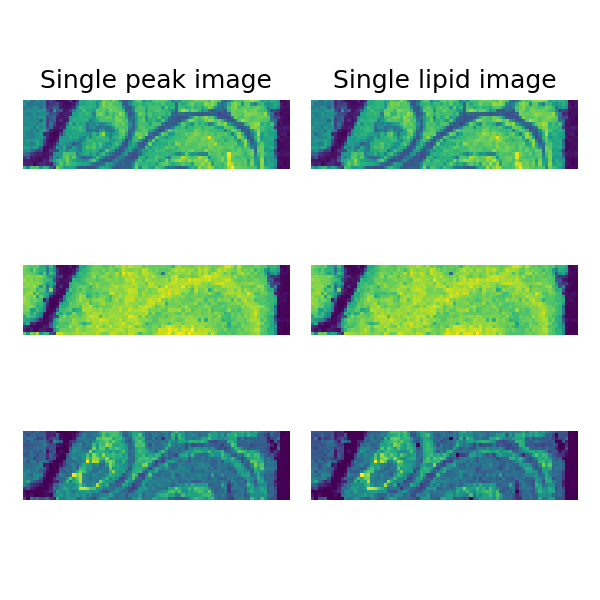

In [26]:
plt.figure(figsize=(4, 4))
plt.subplot(3, 2, 1)
plt.title('Single peak image')
plt.subplot(3, 2, 2)
plt.title('Single lipid image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(3, 2, 1+2*i)
    plt.imshow(control_peak_images[0][..., i])
    plt.axis('off')
    plt.subplot(3, 2, 2+2*i)
    plt.imshow(control_lipid_images[0][..., i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/peak_assignment/cerebellum_example_images.png', dpi=300)

<IPython.core.display.Javascript object>


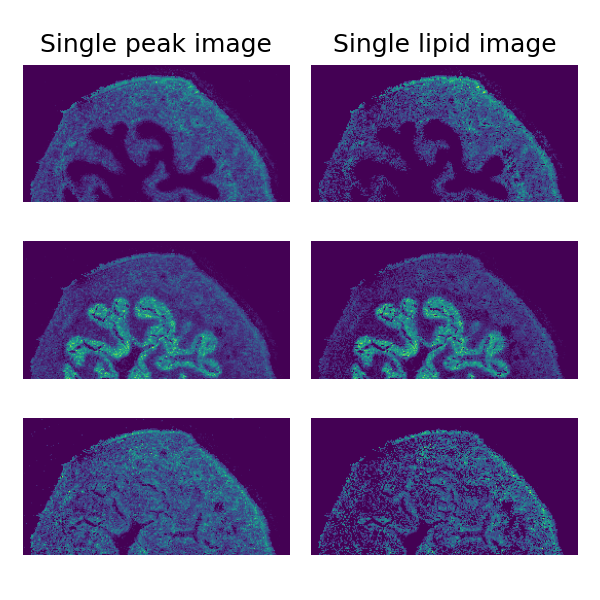

In [27]:
plt.figure(figsize=(4, 4))
plt.subplot(3, 2, 1)
plt.title('Single peak image')
plt.subplot(3, 2, 2)
plt.title('Single lipid image')
for i, n in enumerate(control_lipid_names):
    plt.subplot(3, 2, 1+2*i)
    plt.imshow(control_peak_images[1][..., i])
    plt.axis('off')
    plt.subplot(3, 2, 2+2*i)
    plt.imshow(control_lipid_images[1][..., i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/peak_assignment/bladder_example_images.png', dpi=300)

In case the annotation was done on a subset of pixels, the images above will be rugged. That's ok, because we're interested in peak assignment not in quantification in the whole image. The important thing is that the proportions are similar to the single peak images in locations where the signals were quantified with masserstein.  

In [39]:
np.sum(proportions_in_whole[0]>0)

227

<IPython.core.display.Javascript object>


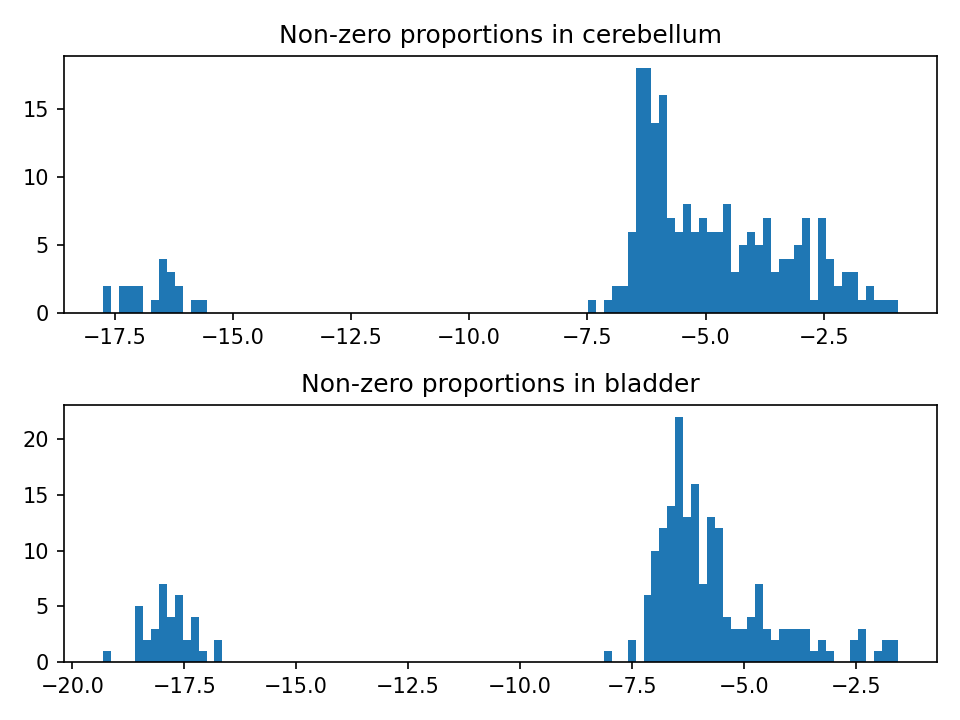

In [46]:
plt.figure()
plt.subplot(211)
pvect = proportions_in_whole[0]
plt.hist(np.log10(pvect[pvect>0]), bins=100)
plt.title('Non-zero proportions in ' + names[0])
plt.subplot(212)
pvect = proportions_in_whole[1]
plt.hist(np.log10(pvect[pvect>0]), bins=100)
plt.title('Non-zero proportions in ' + names[1])
plt.tight_layout() 

Visualize the peak assignment:

cerebellum


<IPython.core.display.Javascript object>


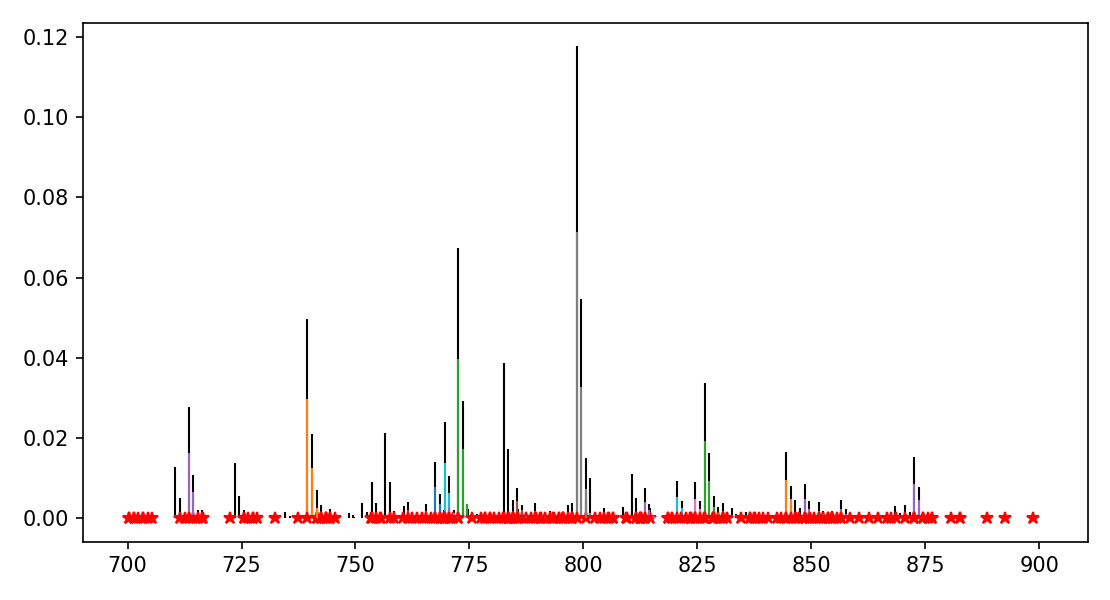

bladder


<IPython.core.display.Javascript object>


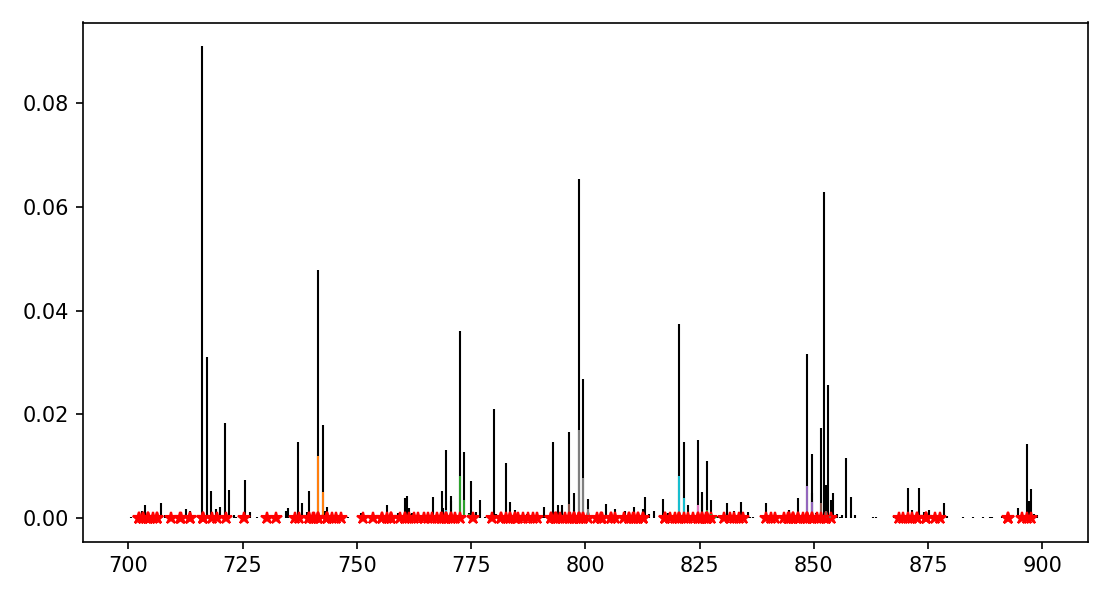

In [43]:
for i, n in enumerate(names):
    print(n)
    plt.figure(figsize=(7.4,4))
    average_spectra[i].plot(profile=False, color='k', show=False)
    for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_whole[i]):
        if p > proportion_threshold:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    plt.savefig('Figs/peak_assignment/' + n + '_annotate_then_average_spectrum.png', dpi=300)
    plt.show()

W cerebellum chcemy lipidy (C38H75N2O6P) 725.49998164145 , \ce{C43H85O7P}, 783.567 Da, oraz \ce{C42H85N2O6P}, 783.578 Da.

In [47]:
selected_lipids = {i: [s for s,p in zip(lipid_spectra, proportions_in_whole[i]) if p > proportion_threshold]}

In [61]:
cer = [s for s,p in zip(lipid_spectra, proportions_in_whole[0]) if p > 1e-8]
len(cer)

207

In [73]:
[lipid_formulas.index(f) for f in ['C38H75N2O6P', 'C43H85O7P', 'C42H85N2O6P']]

[113, 78, 266]

In [69]:
[proportions_in_whole[0][i] for i in [113, 78, 266]]

[1.8579452147390285e-05, 0.0006148453568669167, 3.88536831849203e-05]

In [51]:
cerf = [s.formula for s in cer]

In [52]:
[f in cerf for f in ['C38H75N2O6P', 'C43H85O7P', 'C42H85N2O6P']]

[True, True, True]

Save the annotation results:

In [53]:
for i,n in enumerate(names):
    with open(n + '_annotation_results.tsv', 'w') as h:
        h.write('\t'.join(['Formula', 'Mass', 'Concentration']) + '\n')
        for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_whole[i]):
            if p > proportion_threshold:
                h.write('\t'.join([s.formula, str(round(s.confs[0][0], 4)), str(round(p, 4))]) + '\n')

## Summary of the annotation

Optional: Load the annotations from the previous section, to avoid re-running it

In [62]:
annotated_formulas = {n: [] for n in names}
for n in names:
    with open(n + '_annotation_results.tsv') as h:
        next(h) 
        for l in h:
            l = l.strip().split()
            annotated_formulas[n].append(l[0])
print('Loaded annotations:')
for n in names:
    print(n, len(annotated_formulas[n]))

Loaded annotations:
cerebellum 207
bladder 180


Check if any formula belongs to more than one class

In [63]:
annotated_classes = {n: [set(formula_to_classes[f]) for f in annotated_formulas[n]] for n in names}
all(len(cls) == 1 for cls in annotated_classes[n] for n in names)

True

Create tables of lipid subclasses corresponding to the annotated formulas

In [64]:
all_annotated_subclasses = list(set(scls for n in names for f in annotated_formulas[n] for scls in formula_to_subclasses[f]))
all_annotated_subclasses.sort(key = lambda x: x[-5:])
all_annotated_subclasses

['Glycerophosphocholines [GP01]',
 'Glycerophosphoethanolamines [GP02]',
 'Glycerophosphoserines [GP03]',
 'Glycerophosphoglycerols [GP04]',
 'Glycerophosphoglycerophosphates [GP05]',
 'Glycerophosphoinositols [GP06]',
 'Glycerophosphoinositol bisphosphates [GP08]',
 'Glycerophosphates [GP10]',
 'Oxidized glycerophospholipids [GP20]',
 'Ceramides [SP02]',
 'Phosphosphingolipids [SP03]',
 'Neutral glycosphingolipids [SP05]']

In [65]:
subclass_annotation_tables = {n: np.zeros((len(annotated_formulas[n]), len(all_annotated_subclasses)), dtype='bool') for n in names}
for n in names:
    for fid, f in enumerate(annotated_formulas[n]):
        for scls in formula_to_subclasses[f]:
            scls_id = all_annotated_subclasses.index(scls)
            subclass_annotation_tables[n][fid, scls_id] = True

For each annotated formula, check how many classes it corresponds to

In [66]:
print('Numbers of lipid formulas with a given number of corresponding subclasses:')
for n in names:
    print(n)
    print(np.bincount(np.sum(subclass_annotation_tables[n], axis=1)))

Numbers of lipid formulas with a given number of corresponding subclasses:
cerebellum
[  0 164  39   4]
bladder
[  0 145  34   1]


One formula corresponds to three subclasses. Every formula has at least one class.  

Check how many different subclass assignments there are

In [68]:
for n in names:
    print('Number of lipids in different subclasses in', n, ':')
    scl_counts = Counter(tuple(row) for row in subclass_annotation_tables[n])
    scl_counts = [([scl for scl, t in zip(all_annotated_subclasses, r) if t], scl_counts[r]) for r in scl_counts]
    scl_counts.sort(key = lambda x: x[1], reverse=True)
    for r in scl_counts:
        print(r)

Number of unique subclass assignments in cerebellum :
(['Glycerophosphates [GP10]'], 35)
(['Glycerophosphocholines [GP01]', 'Glycerophosphoethanolamines [GP02]'], 33)
(['Glycerophosphoserines [GP03]'], 31)
(['Glycerophosphoglycerols [GP04]'], 30)
(['Phosphosphingolipids [SP03]'], 23)
(['Neutral glycosphingolipids [SP05]'], 12)
(['Oxidized glycerophospholipids [GP20]'], 9)
(['Glycerophosphocholines [GP01]'], 9)
(['Glycerophosphoethanolamines [GP02]'], 7)
(['Glycerophosphoserines [GP03]', 'Oxidized glycerophospholipids [GP20]'], 5)
(['Ceramides [SP02]'], 5)
(['Glycerophosphocholines [GP01]', 'Glycerophosphoethanolamines [GP02]', 'Oxidized glycerophospholipids [GP20]'], 4)
(['Glycerophosphoinositols [GP06]'], 2)
(['Glycerophosphoglycerols [GP04]', 'Glycerophosphates [GP10]'], 1)
(['Glycerophosphoglycerophosphates [GP05]'], 1)
Number of unique subclass assignments in bladder :
(['Glycerophosphates [GP10]'], 41)
(['Glycerophosphocholines [GP01]', 'Glycerophosphoethanolamines [GP02]'], 32)
(

## An alternative (simpler) approach to annotation: deconvolution of the average spectrum

In [26]:
proportions_in_average = []
regression_times = []
for i, sp in enumerate(average_spectra):
    s = time()
    regression = estimate_proportions(sp, lipid_spectra, MTD=MTD, MTD_th=MTD_th, MDC=1e-09, MMD=1.)
    e = time()
    proportions_in_average.append(np.array(regression['proportions']))
    regression_times.append(e-s)
print('Regression times:')
for n,t in zip(names, regression_times):
    print(n, round(t, 2), 'seconds')

Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:00<00:00, 1245894.24it/s]
Splitting the experimental spectrum into chunks: 3207it [00:00, 1795639.16it/s]
Computing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1171/1171 [00:00<00:00, 3451531.96it/s]
Splitting the experimental spectrum into chunks: 423it [00:00, 2986852.85it/s]
Deconvolving chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.18it/s]

Regression times:
cerebellum 5.02 seconds
bladder 0.96 seconds


<IPython.core.display.Javascript object>


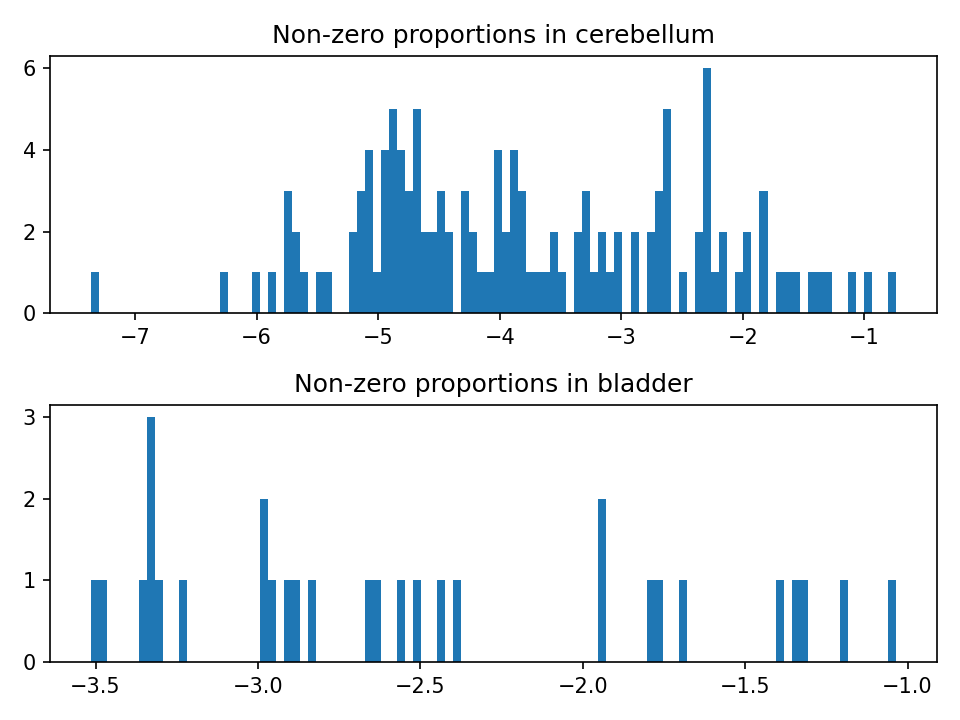

Number of non-zero proportions in cerebellum 128
Number of non-zero proportions in bladder 30


In [28]:
plt.figure()
plt.subplot(211)
pvect = proportions_in_average[0]
plt.hist(np.log10(pvect[pvect>0]), bins=100)
plt.title('Non-zero proportions in ' + names[0])
print('Number of non-zero proportions in', names[0], sum(pvect>0))
plt.subplot(212)
pvect = proportions_in_average[1]
plt.hist(np.log10(pvect[pvect>0]), bins=100)
plt.title('Non-zero proportions in ' + names[1])
print('Number of non-zero proportions in', names[1], sum(pvect>0))
plt.tight_layout() 

cerebellum


<IPython.core.display.Javascript object>


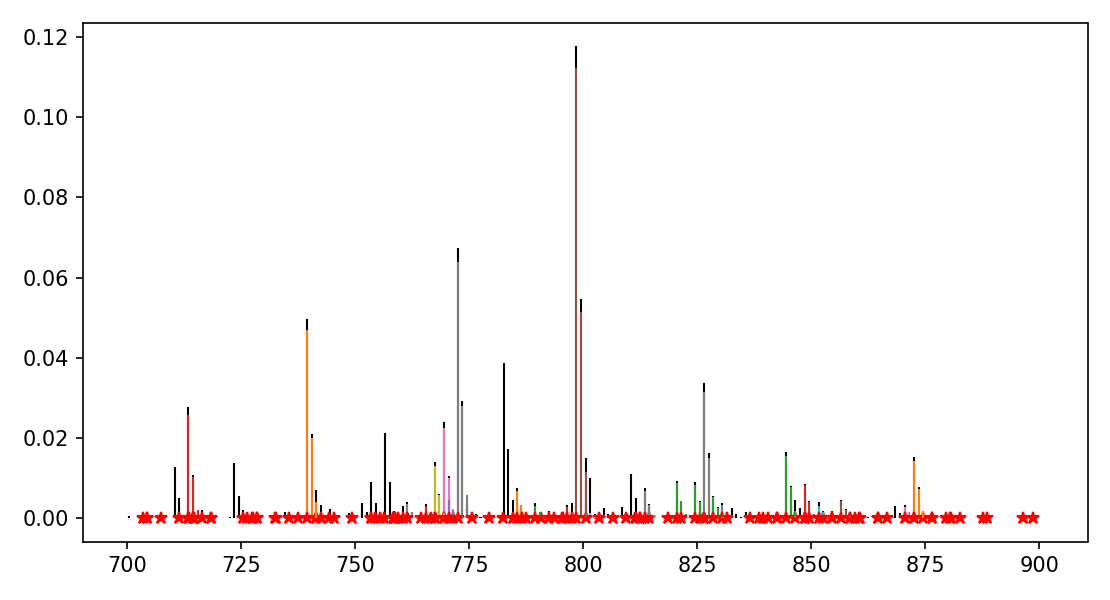

bladder


<IPython.core.display.Javascript object>


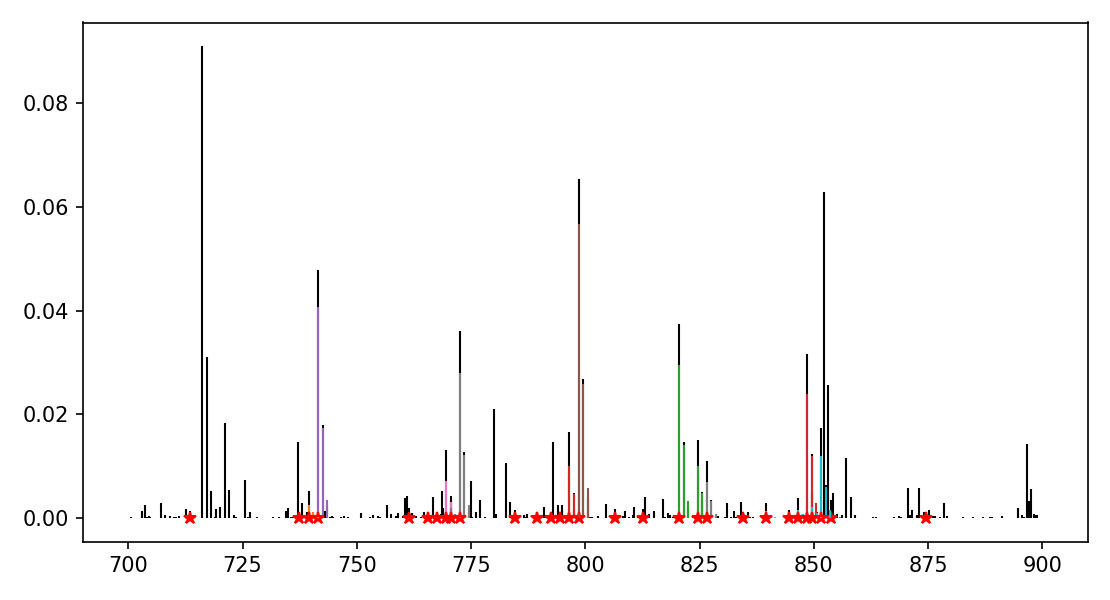

In [23]:
for i, n in enumerate(names):
    print(n)
    plt.figure(figsize=(7.4,4))
    average_spectra[i].plot(profile=False, color='k', show=False)
    for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_average[i]):
        if p > proportion_threshold:
            (s*p).plot(color=cm.tab10(l_id%10), show=False)
            plt.plot(s.confs[0][0], [0], 'r*')
    plt.tight_layout()
    plt.savefig('Figs/peak_assignment/' + n + '_average_then_annotate_spectrum.png', dpi=300)
    plt.show()

In [24]:
for i,n in enumerate(names):
    with open(n + '_average_spectrum_annotation_results.tsv', 'w') as h:
        h.write('\t'.join(['Formula     ', 'Mass', 'Concentration']) + '\n')
        for l_id, s,p in zip(range(len(lipid_spectra)), lipid_spectra, proportions_in_average[i]):
            if p > proportion_threshold:
                h.write('\t'.join([s.formula, str(round(s.confs[0][0], 4)), str(round(p, 4))]) + '\n')